In [1]:
%matplotlib inline
# Simulating the Ising model
from __future__ import division
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import networkx as nx
from networkx import from_numpy_array
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import math
from tqdm import tqdm, trange
from torch_geometric.utils import to_networkx, is_undirected, subgraph
import xml.etree.ElementTree as ET
import random
# from models import *
from Heterophily_and_oversmoothing.model import *
import matplotlib.colors as mcolors
from torch_geometric.utils import to_undirected
import pickle
import os

In [2]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# https://rajeshrinet.github.io/blog/2014/ising-model/
class Ising():
    def __init__(self):
        self.graphs = []
        self.configurations = []
        self.energies = []
        self.N = None     
        self.J = None         
        self.Jb = None        
        self.temp = None  

    ''' Simulating the Ising model '''
    ## monte carlo moves
    def mcmove(self, config, N, J, Jb, mapping, beta):
        ''' This is to execute the monte carlo moves using 
        Metropolis algorithm such that detailed
        balance condition is satisified'''
        energy = 0     

        for _ in range(N**2):            
            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            s =  config[a, b]

            # nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
            nb = 0
            if a>0:
                nb += config[a-1,b]
            if a<N-1:
                nb += config[a+1,b]
            if b>0:
                nb += config[a,b-1]
            if b<N-1:
                nb += config[a,b+1]

            cost = J*s*nb + Jb*mapping(N, a, b)*s

            if cost < 0:	
                s *= -1
            elif rand() < np.exp(-cost*beta):
                s *= -1
            config[a, b] = s

            # calculate energy
            energy -= J*s*nb + Jb*s*mapping(N, a, b)

        return config, energy
    
    def simulate(self, N, J, Jb, temp=0.4, iterations_to_save=[1, 4, 32, 64, 512]):
        ''' This module simulates the Ising model'''
        self.N = N
        self.J = J
        self.Jb = Jb
        self.temp = temp
        config = 2*np.random.randint(2, size=(N,N))-1
        self.configurations.append((0, config.copy()))
        self.energies.append((0, 0))
        self.graphs.append((config.copy(), np.zeros((N,N))))

        def external_field(N, a, b):
            # add some random perturbation to the external field
            return -N + a + b # + np.random.normal(0, 40)

        b_val = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                b_val[i, j] = external_field(N, i, j)*Jb

        msrmnt = 512
        for i in range(msrmnt+1):
            _, energy = self.mcmove(config, N, J, Jb, external_field, 1.0/temp)
            if i in iterations_to_save:
                self.configurations.append((i, config.copy()))
                self.energies.append((i, energy))
                self.graphs.append((config.copy(), b_val.copy()))

    def grouped_plot(self, save=False):
        ''' Save a grouped plot of all saved configurations '''
        grouped_plot = plt.figure(figsize=(15, 15), dpi=80)
        for idx, (iteration, config) in enumerate(self.configurations):
            sp = grouped_plot.add_subplot(3, 3, idx + 1)
            sp.imshow(config)
            sp.set_title(f'Iter: {iteration * self.N * self.N}, Energy: {self.energies[idx][1]:.2f}')
            sp.axis('off')
        if save:
            grouped_plot.savefig(f'ising/plots/grouped_{self.N}_{self.J}_{self.Jb}_{self.temp}.png', dpi=300)
        plt.show()

    def single_plot(self, iteration_index, save_path=None):
        ''' Show a single plot for a specific configuration '''
        iteration, config = self.configurations[iteration_index]
        energy = self.energies[iteration_index][1]

        single_plot = plt.figure(figsize=(6, 6), dpi=100)
        plt.imshow(config)
        plt.title(f'Iter: {iteration * self.N * self.N}, Energy: {energy:.2f}')
        plt.axis('off')
        if save_path is not None:
            single_plot.savefig(save_path, dpi=300)
        plt.show()
        
    def generateGraphs(self):
        nx_graphs = []
        for graph, b_val in self.graphs:
            G = nx.DiGraph()
            for i in range(graph.shape[0]):
                for j in range(graph.shape[1]):
                    node_id = i * graph.shape[1] + j
                    G.add_node(node_id, x=b_val[i, j], y=graph[i, j])
            
            for i in range(graph.shape[0]):
                for j in range(graph.shape[1]):
                    node_id = i * graph.shape[1] + j
                    if i > 0:
                        G.add_edge(node_id, node_id - graph.shape[1], x=b_val[i-1, j], y=graph[i-1, j])
                    if j > 0:
                        G.add_edge(node_id, node_id - 1, x=b_val[i, j-1], y=graph[i, j-1])
                    if i < graph.shape[0] - 1:
                        G.add_edge(node_id, node_id + graph.shape[1], x=b_val[i+1, j], y=graph[i+1, j])
                    if j < graph.shape[1] - 1:
                        G.add_edge(node_id, node_id + 1, x=b_val[i, j+1], y=graph[i, j+1])
            
            nx_graphs.append(G)
        return nx_graphs


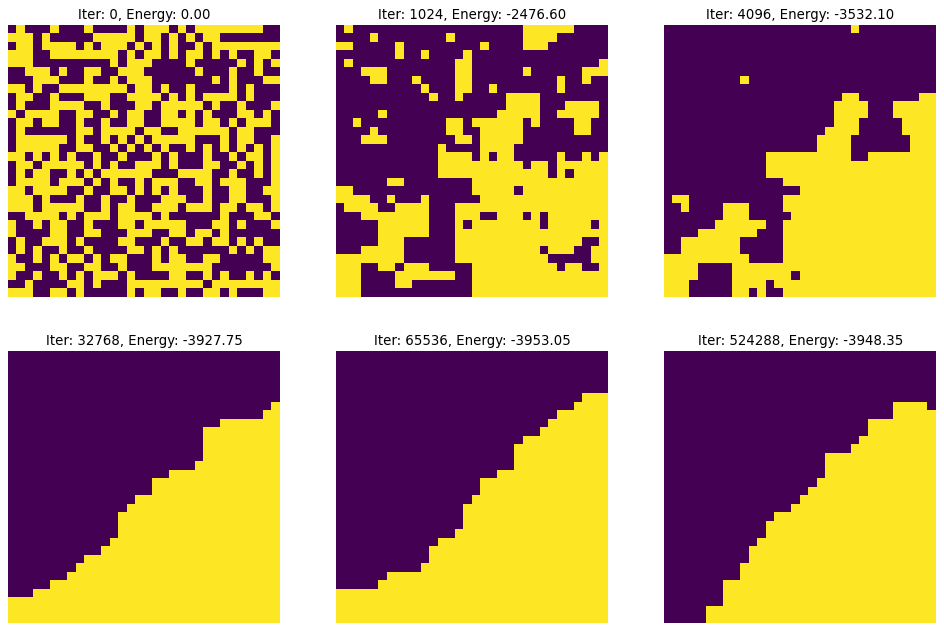

In [4]:
rm = Ising()
N = 32
J = 0.9
Jb = 0.05
temp = 0.4
rm.simulate(N, J, Jb, temp, iterations_to_save=[1, 4, 32, 64, 512])
rm.grouped_plot(save=True)


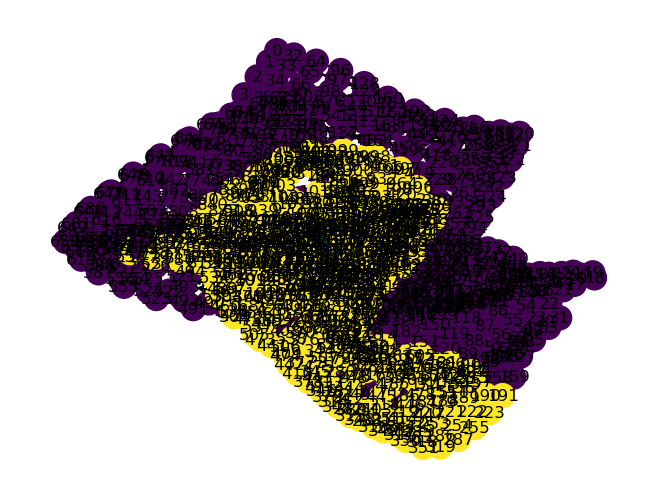

In [5]:
nx_graphs = rm.generateGraphs()
nx.draw(nx_graphs[4], node_color=[nx_graphs[4].nodes[i]['y'] for i in nx_graphs[1].nodes()], with_labels=True)

plt.show()

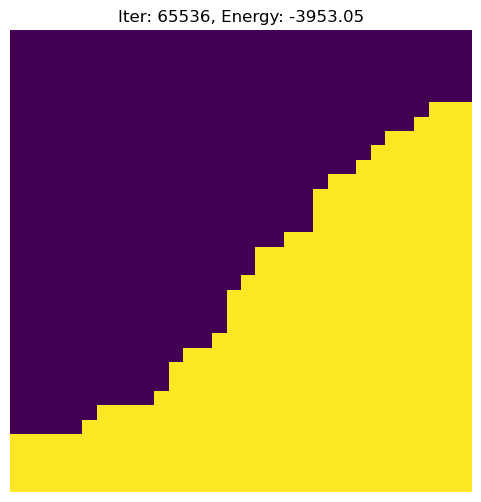

In [6]:
rm.single_plot(4, save_path=None)


In [7]:
def edge_homophily(pyg_data):
    edge_index = pyg_data.edge_index
    y = pyg_data.y
    num_same = 0
    num_edges = edge_index.size(1)
    for i in range(num_edges):
        src_label = y[edge_index[0, i]].item()
        trg_label = y[edge_index[1, i]].item()
        if src_label == trg_label:
            num_same += 1
    return num_same / num_edges

def count_classes(G):
    class_counts = {}
    for node in G.nodes():
        if G.nodes[node]['y'] not in class_counts:
            class_counts[G.nodes[node]['y']] = 0
        class_counts[G.nodes[node]['y']] += 1
    return class_counts

def create_splits(num_nodes, train_ratio=0.48, val_ratio=0.32):
    indices = np.random.permutation(num_nodes - 2) + 1  # exclude the first and last nodes
    
    train_size = int(train_ratio * (num_nodes - 2))
    val_size = int(val_ratio * (num_nodes - 2))
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    masks = {
        'train_mask': train_mask,
        'val_mask': val_mask,
        'test_mask': test_mask
    }

    with open(f'ising/masks/mask.pkl', 'wb') as f:
        pickle.dump(masks, f)
    
    return train_mask, val_mask, test_mask
    

def create_random_splits(gdata, train_ratio=0.48, val_ratio=0.32):
    num_nodes = gdata.num_nodes
    indices = np.random.permutation(num_nodes - 2) + 1  # exclude the first and last nodes
    
    train_size = int(train_ratio * (num_nodes - 2))
    val_size = int(val_ratio * (num_nodes - 2))
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # include the first and last nodes in the test mask
    test_mask[0] = True
    test_mask[-1] = True
    
    return train_mask, val_mask, test_mask

def graph_to_data(G):
    data = from_networkx(G)
    data.x = torch.tensor([[node[1]['x']] for node in G.nodes(data=True)], dtype=torch.float)
    data.y = torch.tensor([node[1]['y'] if node[1]['y']==1 else 0 for node in G.nodes(data=True)], dtype=torch.long)

    mask_path = 'ising/masks/mask.pkl'
    if os.path.exists(mask_path):
        with open(mask_path, 'rb') as f:
            masks = pickle.load(f)
        data.train_mask = masks['train_mask']
        data.val_mask = masks['val_mask']
        data.test_mask = masks['test_mask']
    else:
        data.train_mask, data.val_mask, data.test_mask = create_splits(data.num_nodes)

    # data.train_mask, data.val_mask, data.test_mask = create_random_splits(data)
    
    return data

In [8]:
nx_graphs = rm.generateGraphs()
data = []
for i, graph in enumerate(nx_graphs):
    pyd = graph_to_data(graph)
    print(f"edge-h [{i}]: {edge_homophily(pyd)}")
    data.append(pyd)

torch.save(data, f'ising/data/ising_data_{N}_{J}_{Jb}_{temp}.pt')

edge-h [0]: 0.4934475806451613
edge-h [1]: 0.8029233870967742
edge-h [2]: 0.9264112903225806
edge-h [3]: 0.9722782258064516
edge-h [4]: 0.9722782258064516
edge-h [5]: 0.9727822580645161


In [9]:
for i, graph in enumerate(nx_graphs):
    count = count_classes(graph)
    print(f'[{i}] 1:{count[1]/(count[1]+count[-1])}\t0:{count[-1]/(count[1]+count[-1])}')

with_node_noise = False

[0] 1:0.5078125	0:0.4921875
[1] 1:0.44140625	0:0.55859375
[2] 1:0.4287109375	0:0.5712890625
[3] 1:0.4453125	0:0.5546875
[4] 1:0.453125	0:0.546875
[5] 1:0.43359375	0:0.56640625


### Adding noise to the node attributes

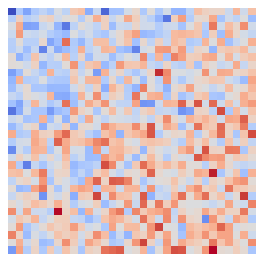

In [10]:
import copy

features_2D = np.zeros((N, N))
features_2D_noisy = np.zeros((N, N))
noisy_data = copy.deepcopy(data)

for i in range(N):
    for j in range(N):
        val = np.random.normal(0, N*abs(Jb))
        features_2D[i, j] = data[4].x[i*N+j][0].item()
        features_2D_noisy[i, j] = data[4].x[i*N+j][0].item() + val
        if with_node_noise:
            for k in range(len(data)):
                noisy_data[k].x[i*N+j][0] = data[k].x[i*N+j][0].item() + val

# fig, ax = plt.subplots(1, 2, figsize=(6, 6))
# ax[0].imshow(features_2D, cmap='coolwarm')
# ax[1].imshow(features_2D_noisy, cmap='coolwarm')
# fig.tight_layout()
# plt.show()

plt.figure(figsize=(4,4), dpi=80)
plt.imshow(features_2D_noisy, cmap='coolwarm')
plt.axis('tight')
plt.axis('off')
plt.show()

In [11]:
data[4].train_mask.sum(), data[4].val_mask.sum(), data[4].test_mask.sum()

(tensor(490), tensor(327), tensor(205))

# Ground truth homophily

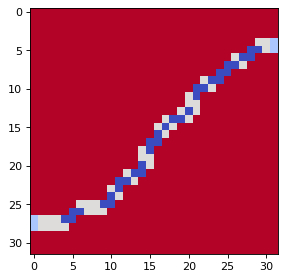

In [12]:
def gt_homphily(data):
    data.edge_index = to_undirected(data.edge_index)
    local_edge_hom = np.zeros(data.y.shape[0])
    for i in range(data.x.size()[0]):
        num_neigh = 0
        for edges in data.edge_index[:, data.edge_index[0] == i].t():
            nbr = edges[1].item()
            if data.y[edges[1]].item() == data.y[i].item():
                local_edge_hom[i] += 1
            num_neigh += 1
        if num_neigh > 0:
            local_edge_hom[i] = local_edge_hom[i] / num_neigh
    
    return local_edge_hom

one_data = data[4].clone()

gt_hom = gt_homphily(one_data.clone())

hom_2D = np.zeros((N, N))
for i in range(one_data.x.size()[0]):
    hom_2D[i // N, i % N] = gt_hom[i]

plt.figure(figsize=(4,4), dpi=80)
plt.imshow(hom_2D, cmap='coolwarm')
plt.axis('tight')
plt.show()


SignificanceResult(statistic=0.60469883201961, pvalue=3.7338318579112945e-198)
absolute diff mean 0.025537634408602152


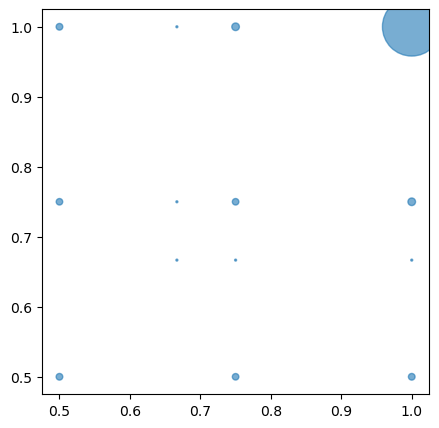

In [13]:
from scipy import stats

def compute_local_homophily(G, node, attr='y'):
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return -1 
    node_attr = G.nodes[node][attr]
    same = sum(1 for n in neighbors if G.nodes[n][attr] == node_attr)
    return same / len(neighbors)

x_vals = []
y_vals = []
G = to_networkx(data[4])
G = G.to_undirected()
for i, n in enumerate(G.nodes()):
    G.nodes[i]['y'] = data[4].y[i].item()

homophily = {node: compute_local_homophily(G, node) for node in G.nodes()}


for i, j in G.edges():
    x_vals.append(homophily[i])
    y_vals.append(homophily[j])

diff = np.abs(np.array(x_vals)-np.array(y_vals))

from collections import Counter
coord_counts = Counter(zip(x_vals, y_vals))
unique_coords = np.array(list(coord_counts.keys()))
sizes = np.array(list(coord_counts.values()))

scaled_sizes = sizes * 1

plt.figure(figsize=(5,5))

# labels = ['<25%', '25% - 50%', '50% - 75%', '>75%']
print(stats.spearmanr(x_vals, y_vals))
print(f"absolute diff mean {diff.mean()}")
sc = plt.scatter(unique_coords[:, 0], unique_coords[:, 1], s=scaled_sizes, alpha=0.6) #, edgecolors='k')
# plt.legend(*sc.legend_elements("sizes", num=7), loc=(1.04, 0))

plt.show()


# Homophily propagation

In [14]:
from torch_geometric.utils import to_undirected

def propagate_homphily3(data, iterations=100, tolerance=0.0001):        
    data.edge_index = to_undirected(data.edge_index)
    hom = np.zeros(data.y.shape[0])
    train_hom  = np.zeros(data.y.shape[0])

    all_nodes =  np.arange(0, data.x.size()[0])
    train_nodes = np.arange(0, data.x.size()[0])[(data.train_mask | data.val_mask)]
    train_mask = data.train_mask | data.val_mask
    test_nodes = np.arange(0, data.x.size()[0])[~(data.train_mask | data.val_mask)]

    # compute local homophily on the training nodes
    nodes_to_init = [] # save the nodes that need to be assigned with the init values
    for i in range(data.x.size()[0]):
        if train_mask[i]:
            num_neigh = 0; hom[i]=0
            for edge in data.edge_index[:, data.edge_index[0] == i].t():
                nbr = edge[1].item()
                if train_mask[nbr]:
                    if data.y[edge[1]].item() == data.y[i].item():
                        hom[i] += 1
                    num_neigh += 1
            if num_neigh > 0:
                hom[i] = hom[i] / num_neigh
                train_hom[i] = hom[i]
            else:
                nodes_to_init.append(i)
    
    init_value = train_hom.sum() / (len(train_nodes)-len(nodes_to_init))
    print("avg train-edge-hom: ", init_value)
    # fill the test nodes with the initial values (avg train hom)
    hom[test_nodes] = init_value
    hom[nodes_to_init] = init_value
    
    # propagate the homophily on the node which is not possible to compute directly the hom value
    converged = False
    for iter in range(iterations):
        converged = True
        for node in range(data.x.size()[0]):
            hom_prev = hom[node]
            neigh = [edge[1].item() for edge in data.edge_index[:, data.edge_index[0] == node].t()]
            train_neigh = np.intersect1d(neigh, train_nodes)
            test_neigh = np.intersect1d(neigh, test_nodes)

            # if node is test or a train with all test nodes as neighbor
            if node in test_nodes or (node in train_nodes and len(train_neigh)==0):
                hom[node] = 0; 
                for nbr in neigh:
                    hom[node] += hom[nbr]
                hom[node] = hom[node]/len(neigh) if len(neigh) > 0 else init_value
            
            # if node is a train node with at least one test node as neighbor
            elif node in train_nodes and len(test_neigh) > 0:
                avg_test_hom = 0
                for nbr in test_neigh:
                    avg_test_hom += hom[nbr]
                avg_test_hom /= len(test_neigh)
                hom[node] = (train_hom[node]*len(train_neigh) + avg_test_hom*len(test_neigh)) / (len(train_neigh)+len(test_neigh))
            if abs(hom_prev - hom[node]) > tolerance:
                converged = False
        
        assert hom[i]>=0 and hom[i]<=1, f"invalid hom: {hom[i]}!!"  
        if converged:
            print(f"2 - Converged at iteration {iter + 1}")
            break

    return hom


avg train-edge-hom:  0.9710633946830267
2 - Converged at iteration 15


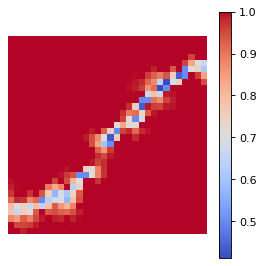

In [15]:
propagated_hom = propagate_homphily3(one_data.clone(), iterations=1000, tolerance=0.0001)

hom_2D = np.zeros((N, N))
hom_2D_2 = np.zeros((N, N))
for i in range(one_data.x.size()[0]):
    hom_2D[i // N, i % N] = propagated_hom[i]

plt.figure(figsize=(4,4), dpi=80)
plt.imshow(hom_2D, cmap='coolwarm')
plt.colorbar()
plt.axis('off')
# plt.axis('tight')
plt.show()

